In [1]:
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"
import sys
from utils.tools import load_obj, save_obj
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm
import os

In [2]:
def iewt1d(ewt, mfb):
    # 转化为原始信号
    real = all(np.isreal(ewt[0]))
    if real:
        rec = np.zeros(len(ewt[0]))
        for i in range(0,len(ewt)):
            rec += np.real(np.fft.ifft(np.fft.fft(ewt[i])*mfb[i]))
    else:
        rec = np.zeros(len(ewt[0]))*0j
        for i in range(0,len(ewt)):
            rec += np.fft.ifft(np.fft.fft(ewt[i])*mfb[i])
    return rec

In [3]:
def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))
def cal_metrics(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    mape = MAPE(pred, true)
    return {"rmse":rmse, "r2":r2, "mape":mape}

## 数据加载

In [4]:
prefixDict = dict(zip(["wti", "brent"], 
                        ["WTI", "Brent"]))
TARGET = "wti"
cols = [TARGET]
if TARGET[0].isdigit():
    df = pd.read_csv(f"./data/oil/{TARGET}.csv", index_col=[0], parse_dates=True)
else:
    df = pd.read_csv(f"./data/oil/{TARGET}.csv", index_col=[0])
df.head()

,wti,wti0,wti1,wti2,wti0_mfb,wti1_mfb,wti2_mfb
Date,,,,,,,
1986-01-02,25.56,41.658271,11.950289,-21.572793,1.000000,0.000000,0.0
1986-01-03,26.00,41.635425,11.894830,-22.346079,1.000000,0.000000,0.0
1986-01-06,26.53,41.612562,11.839107,-20.558484,1.000000,0.000000,0.0
1986-01-07,25.85,41.589681,11.783121,-22.236791,0.966184,0.257855,0.0
1986-01-08,25.87,41.566782,11.726873,-21.252425,0.257855,0.966184,0.0


## nonformer-ewt 预测

In [5]:
N = 3
dataset = "oil"

In [28]:
nonformer_metrics_dict = {}
seq_len, pred_len = 60, 1
total_len = len(df)
HORIZON = 10

nonformerNameDict = dict(zip(["mlp", "lstm", "tpa", "tcn", "trans"], 
                         ["MLP","LSTM", "TPA", "TCN", "LogTrans"]))

In [41]:
for model_name in ["lstm"]:#nonformerNameDict.keys():
    # 不同horizon下的分量预测结果
    ewt_horizon_dict = {}
    for hn in range(1, HORIZON+1):
        # 加载不同horizon下的各分量预测结果
        pred_lst = []
        # true_lst = []
        for i in range(N):
            true, pred = load_obj(f"./results/{dataset}/{model_name}_{dataset}_ftS_sl{seq_len}_ll0_pl{pred_len}_is1_os1_hn{hn}_bs32_lr0.001_{TARGET}{i}_0/true_pred.pkl")
            # true_lst.append(true)
            pred_lst.append(pred)
        pred_ = np.concatenate(pred_lst,axis=-1)
        # true_ = np.concatenate(true_lst, axis=-1)
        ewt_horizon_dict[hn] = pred_
    # 逆过程    
    target_horizon = 1
    ewt_metrics = {} # 不同horizon的cal_metrics
    # 记录所有horizon下test_data的结果，用于计算整体metrics
    trues_test_lst, preds_test_lst = [], []
    for horizon in range(1, HORIZON+1):
        out_len = max(pred_len, horizon)
        gap = horizon - 1
        length = total_len - seq_len - out_len + 1
        test_size = int(length*0.2)
        cut_point = length - test_size
        pred_startpoint = cut_point + seq_len + gap

        pre_len = seq_len + gap
        for col in cols:
            tmp_mfb = df[[f"{col}{i}_mfb" for i in range(N)]].values
            # seq_len部分的ewt
            pre_ewt = df.iloc[:pre_len][[f"{col}{i}" for i in range(N)]]
            # 和预测得到的ewt组合
            pred_horizon = ewt_horizon_dict[horizon][:,0,:]
            # pred_horizon = pred_[:,target_horizon-1,:]]
            ewt_pred = np.concatenate([pre_ewt, pred_horizon], axis=0)
            # 重构
            reconstruction = iewt1d(ewt_pred.T, tmp_mfb.T)
            target = df[col]
            # 预测评估
            trues_test = target.values[pred_startpoint:]
            preds_test = reconstruction[pred_startpoint:]
            trues_test_lst.append(trues_test)
            preds_test_lst.append(preds_test)

            ewt_metrics[f"horizon{horizon}"] = cal_metrics(trues_test, preds_test)
        if horizon == target_horizon:
            ewt_target_horizon_data = [target, reconstruction, ewt_pred]
    trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
    ewt_metrics["avghorizon"] = cal_metrics(trues_test_all, preds_test_all)
    nonformer_metrics_dict[f"{nonformerNameDict.get(model_name)}-EWT"] = pd.DataFrame(ewt_metrics).T

In [42]:
nonformer_metrics_dict["LSTM-EWT"]

,rmse,r2,mape
horizon1,4.148287,0.944177,0.057625
horizon2,4.573294,0.932152,0.070861
horizon3,4.525385,0.933566,0.058780
horizon4,4.491470,0.934558,0.063360
horizon5,4.427018,0.936447,0.062086
horizon6,4.772062,0.926155,0.065581
horizon7,5.215537,0.911792,0.072762
horizon8,4.711872,0.928006,0.068797
horizon9,4.867877,0.923160,0.073834
horizon10,5.143316,0.914255,0.076285


In [43]:
cal_metrics(trues_test, preds_test)

{'rmse': 5.1433155287880385,
 'r2': 0.914255225272539,
 'mape': 0.07628492754556884}

In [69]:
# 多变量
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
tmp_target = target.values
train_size = int(ewt_pred.shape[0]*0.7)
X_train,X_test,y_train,y_test = ewt_pred[:train_size], ewt_pred[train_size:], tmp_target[:train_size], tmp_target[train_size:]

In [77]:
model = SVR()
model.fit(X_train, y_train)
y_pred = model.predict(ewt_pred[pred_startpoint:])
y_true = tmp_target[pred_startpoint:]
np.sqrt(mean_squared_error(y_true, y_pred))

SVR()

9.67204919272172

In [ ]:
y_pred = model.predict(X_test)
y_true = y_test
np.sqrt(mean_squared_error(y_true, y_pred))

9.628391395375672

In [79]:
r2_score(y_true, y_pred)

0.6967796664119564

In [70]:
param_grid = {"gamma":[0.001,0.01,0.1,1,10,100],
             "C":[0.001,0.01,0.1,1,10,100]}
print("Parameters:{}".format(param_grid))
grid_search = GridSearchCV(SVR(),param_grid,cv=5) #实例化一个GridSearchCV类

grid_search.fit(X_train,y_train) #训练，找到最优的参数，同时使用最优的参数实例化一个新的SVC estimator。
print("Test set score:{:.2f}".format(grid_search.score(X_test,y_test)))
print("Best parameters:{}".format(grid_search.best_params_))
print("Best score on train set:{:.2f}".format(grid_search.best_score_))

Parameters:{'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

Test set score:0.82
Best parameters:{'C': 10, 'gamma': 0.001}
Best score on train set:-0.72


In [73]:
r2_score(grid_search.predict(X_test), y_test)

0.8162870737077637

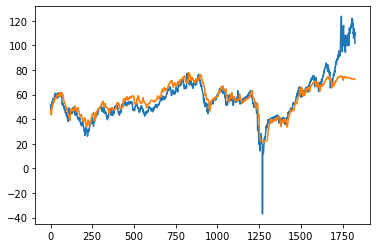

In [56]:
plt.plot(y_true)
plt.plot(y_pred)

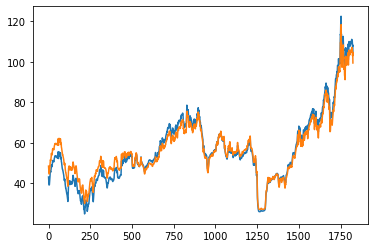

In [58]:
y_pred1 = np.sum(ewt_pred, axis=1)[pred_startpoint:]
y_pred2 = iewt1d(ewt_pred.T, tmp_mfb.T)[pred_startpoint:]
plt.plot(y_pred1)
plt.plot(y_pred2)
# plt.plot(y_true)

In [24]:
nonformer_metrics_dict["LSTM-EWT"]

,rmse,r2,mape
horizon1,2.319326,0.982550,0.028055
horizon2,3.347458,0.963650,0.045316
horizon3,3.274782,0.965211,0.044665
horizon4,3.459759,0.961170,0.046007
horizon5,3.864306,0.951577,0.053278
horizon6,4.191900,0.943019,0.059327
horizon7,4.438175,0.936127,0.064621
horizon8,4.813826,0.924856,0.071147
horizon9,5.508998,0.901586,0.085761
horizon10,4.976316,0.919733,0.072778


### target_horizon展示

In [8]:
# target, reconstruction, ewt_pred = ewt_target_horizon_data
# gap = target_horizon - 1

In [9]:
# for col in cols:
#     fig = plt.figure(figsize=(20, 15))
#     _ = plt.subplot(N+1, 1, 1)
#     _ = plt.plot(range(pred_startpoint-gap), target.values[:pred_startpoint-gap])
#     _ = plt.plot(range(pred_startpoint, len(df)), reconstruction[pred_startpoint:])
#     ax = plt.gca()
#     _ = plt.vlines(pred_startpoint-gap, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
#     _ = plt.ylabel(f"{col}");
#     for i in range(N):
#         _ = plt.subplot(N+1, 1, i+2)
#         _ = plt.plot(range(pred_startpoint-gap), df[f"{col}{i}"][:pred_startpoint-gap], )
          
#         _ = plt.plot(range(pred_startpoint, len(df)), ewt_pred[:, i][pred_startpoint:])
#         ax = plt.gca()
#         _ = plt.vlines(pred_startpoint, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
#         _ = plt.ylabel(f"IMF{i+1}");

In [10]:
# fig.savefig(f"./savefig/{TARGET}_{model_name}ewt0.png")

In [11]:
# fig = plt.figure(figsize=(20, 5))
# plt.plot(range(pred_startpoint, len(df)), target.values[pred_startpoint:], label="true")
# plt.plot(range(pred_startpoint, len(df)), reconstruction[pred_startpoint:], label="predict")
# plt.legend();

In [12]:
# fig.savefig(f"./savefig/{TARGET}_{model_name}ewt1.png")

In [13]:
# fig = plt.figure(figsize=(20, 5))
# select_length = 100
# plt.plot(range(len(df)-select_length, len(df)), target.values[-select_length:], '-o', label="true")
# plt.plot(range(len(df)-select_length, len(df)), reconstruction[-select_length:], '-o', label="predict")
# plt.legend();

In [14]:
# fig.savefig(f"./savefig/{TARGET}_{model_name}ewt2.png")

## nonformer 预测

In [21]:
tmp_nonformerNameDict = {}
tmp_nonformerNameDict.update(**nonformerNameDict)
tmp_nonformerNameDict.update(**dict(zip(["mlpdecompose","tpadecompose", "lstmdecompose", "tcndecompose", "transdecompose"],
                                       ["MLP-De","TPA-De", "LSTM-De", "TCN-De", "LogTrans-De"])))
# tmp_nonformerNameDict = {"lstm":"LSTM", "lstmdecompose":"LSTM-De"}

In [22]:
for model_name in list(tmp_nonformerNameDict.keys()):
    _horizon_dict = {}
    for hn in range(1, HORIZON+1):
        
        true, pred = load_obj(f"./results/{dataset}/{model_name}_{dataset}_ftS_sl{seq_len}_ll0_pl{pred_len}_is1_os1_hn{hn}_bs32_lr0.001_{TARGET}_0/true_pred.pkl")
        
            # path = r"D:\IDEA\Spatial-temporal\deep-time-series"
            # true, pred = load_obj(os.path.join(path, f"results/google1/{model_name}_google1_ftS_sl{seq_len}_ll0_pl{pred_len}_is1_os1_hn{hn}_bs32_lr0.001_{TARGET}_0/true_pred.pkl"))
        _horizon_dict[hn] = pred

    target_horizon = 1
    _metrics = {}
    # 记录所有horizon下test_data的结果，用于计算整体metrics
    trues_test_lst, preds_test_lst = [], []
    for horizon in range(1, HORIZON+1):
        out_len = max(pred_len, horizon)
        gap = horizon - 1
        length = total_len - seq_len - out_len + 1
        test_size = int(length*0.2)
        cut_point = length - test_size
        pred_startpoint = cut_point + seq_len + gap

        pre_len = seq_len + gap
        for col in cols:
            # seq_len部分的col
            pre_col = df.iloc[:pre_len][[col]]
            # 和预测得到的col组合
            pred_horizon = _horizon_dict[horizon][:,0,:]
            pred_horizon = np.concatenate([pre_col, pred_horizon], axis=0)
            target = df[col]
            # 预测评估
            trues_test = target.values[pred_startpoint:]
            preds_test = pred_horizon[pred_startpoint:]
            trues_test_lst.append(trues_test)
            preds_test_lst.append(preds_test.flatten())

            _metrics[f"horizon{horizon}"] = cal_metrics(trues_test, preds_test)
        if horizon == target_horizon:
            _target_horizon_data = [target, pred_horizon]

    trues_test_all, preds_test_all = np.concatenate(trues_test_lst), np.concatenate(preds_test_lst)
    _metrics["avghorizon"] = cal_metrics(trues_test_all, preds_test_all)
    nonformer_metrics_dict[f"{tmp_nonformerNameDict.get(model_name, model_name)}"] = pd.DataFrame(_metrics).T

In [23]:
nonformer_metrics_dict["LSTM"]

,rmse,r2,mape
horizon1,2.314069,0.982629,0.355941
horizon2,2.898478,0.972747,0.354352
horizon3,3.597667,0.958013,0.352196
horizon4,3.770562,0.953880,0.357079
horizon5,4.368548,0.938115,0.360114
horizon6,4.602205,0.931318,0.358396
horizon7,4.574635,0.932138,0.353865
horizon8,4.724885,0.927608,0.352583
horizon9,4.867105,0.923184,0.348943
horizon10,5.028954,0.918026,0.349294


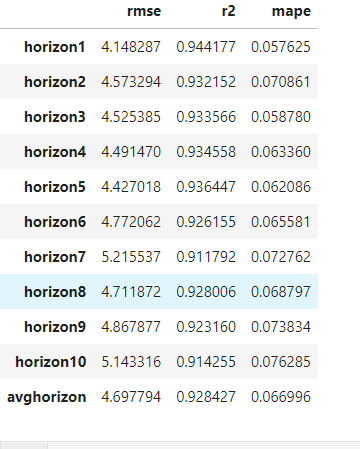

## former-ewt 预测

In [26]:
former_metrics_dict = {}

seq_len, label_len, pred_len = 60, 30, 10
batch_size = 32
HORIZON = pred_len
# seq_len, label_len, pred_len = 96, 32, 64
# batch_size = 8

total_len = len(df)
target_horizon_data_dict = {}
target_horizon = 1
formerNameDict = dict(zip(["informer", "transformer"], 
                         ["In", "Trans"]))

In [27]:
for model_name in formerNameDict.keys():
    # 读取数据
    ewt_pred_lst = []
    for i in range(N):
        true_, pred_ = load_obj(f"./results/{dataset}/{model_name}_{dataset}_ftS_sl{seq_len}_ll{label_len}_pl{pred_len}_is1_os1_hn1_bs{batch_size}_lr0.0001_{TARGET}{i}_0/true_pred.pkl")
        ewt_pred_lst.append(pred_)
    model_ewt_pred = np.concatenate(ewt_pred_lst,axis=-1)    
    
    ewt_metrics = {}
    # 记录所有horizon下test_data的结果，用于计算整体metrics
    trues_test_lst, preds_test_lst = [], []
    for horizon in range(1, HORIZON+1):
        out_len = max(pred_len, horizon)
        gap = horizon - 1
        length = total_len - seq_len - out_len + 1
        test_size = int(length*0.2)
        cut_point = length - test_size
        pred_startpoint = cut_point + seq_len + gap

        pre_len = seq_len + gap
        for col in cols:
            # former多步预测时，截断了最后horizon个步长，为了对齐，要截断
            align_len = pred_len-horizon
            align_len = -total_len if align_len<=0 else align_len
            tmp_mfb = df[[f"{col}{i}_mfb" for i in range(N)]].values[:-align_len]
            # seq_len部分的ewt
            pre_ewt = df.iloc[:pre_len][[f"{col}{i}" for i in range(N)]]
            # 和预测得到的ewt组合
            pred_horizon = model_ewt_pred[:,horizon-1,:]
            ewt_pred = np.concatenate([pre_ewt, pred_horizon], axis=0)
            # 重构
            reconstruction = iewt1d(ewt_pred.T, tmp_mfb.T)
            target = df[col][:-align_len]
            # 预测评估
            trues_test = target.values[pred_startpoint:]
            preds_test = reconstruction[pred_startpoint:]
            trues_test_lst.append(trues_test)
            preds_test_lst.append(preds_test)

            ewt_metrics[f"horizon{horizon}"] = cal_metrics(trues_test, preds_test)
        if horizon == target_horizon:
            ewt_target_horizon_data = [target, reconstruction, ewt_pred]
            target_horizon_data_dict[model_name+"ewt"] = ewt_target_horizon_data
            
    trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
    ewt_metrics["avghorizon"] = cal_metrics(trues_test_all, preds_test_all)
    former_metrics_dict[f"{formerNameDict.get(model_name)}-EWT"] = pd.DataFrame(ewt_metrics).T

### target_horizon展示

In [76]:
# show_model = "auto"
# target, reconstruction, ewt_pred = target_horizon_data_dict[show_model+"ewt"]
# gap = target_horizon-1

In [77]:
# for col in cols:
#     fig = plt.figure(figsize=(20, 15))
#     _ = plt.subplot(N+1, 1, 1)
#     _ = plt.plot(range(pred_startpoint-gap), target.values[:pred_startpoint-gap])
#     _ = plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), reconstruction[pred_startpoint:])
#     ax = plt.gca()
#     _ = plt.vlines(pred_startpoint-gap, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
#     _ = plt.ylabel(f"{col}");
#     for i in range(N):
#         _ = plt.subplot(N+1, 1, i+2)
#         _ = plt.plot(range(pred_startpoint-gap), df[f"{col}{i}"][:pred_startpoint-gap], )
          
#         _ = plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), ewt_pred[:, i][pred_startpoint:])
#         ax = plt.gca()
#         _ = plt.vlines(pred_startpoint, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
#         _ = plt.ylabel(f"IMF{i+1}");

In [78]:
# fig.savefig(f"./savefig/{TARGET}_{model_name}ewt0.png")

In [79]:
# fig = plt.figure(figsize=(20, 5))
# plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), target.values[pred_startpoint:], label="true")
# plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), reconstruction[pred_startpoint:], label="predict")
# plt.legend();

In [80]:
# fig.savefig(f"./savefig/{TARGET}_{model_name}ewt1.png")

In [81]:
# fig = plt.figure(figsize=(20, 5))
# select_length = 100
# plt.plot(range(len(df)-pred_len+target_horizon-select_length, len(df)-pred_len+target_horizon), target.values[-select_length:], '-o', label="true")
# plt.plot(range(len(df)-pred_len+target_horizon-select_length, len(df)-pred_len+target_horizon), reconstruction[-select_length:], '-o', label="predict")
# plt.legend();

In [82]:
# fig.savefig(f"./savefig/{TARGET}_{model_name}ewt2.png")

## former预测

In [53]:
tmp_formerNameDict = {}
tmp_formerNameDict.update(**formerNameDict)
tmp_formerNameDict.update(**dict(zip(["transformerdecompose", "informerdecompose"],
                                       ["Trans-De", "In-De"])))

In [54]:
for model_name in tmp_formerNameDict.keys():
    _true, _pred = load_obj(f"./results/{dataset}/{model_name}_{dataset}_ftS_sl{seq_len}_ll{label_len}_pl{pred_len}_is1_os1_hn1_bs{batch_size}_lr0.0001_{TARGET}_0/true_pred.pkl")

    _metrics = {}
    # 记录所有horizon下test_data的结果，用于计算整体metrics
    trues_test_lst, preds_test_lst = [], []
    for horizon in range(1, HORIZON+1):
        out_len = max(pred_len, horizon)
        gap = horizon - 1
        length = total_len - seq_len - out_len + 1
        test_size = int(length*0.2)
        cut_point = length - test_size
        pred_startpoint = cut_point + seq_len + gap

        pre_len = seq_len + gap
        for col in cols:
            align_len = pred_len-horizon
            align_len = -total_len if align_len<=0 else align_len
            # seq_len部分的col
            pre_col = df.iloc[:pre_len][[col]]
            # 和预测得到的col组合
            pred_horizon = _pred[:,horizon-1,:]
            pred_horizon = np.concatenate([pre_col, pred_horizon], axis=0)
            target = df[col][:-align_len]
            # 预测评估
            trues_test = target.values[pred_startpoint:]
            preds_test = pred_horizon[pred_startpoint:]
            trues_test_lst.append(trues_test)
            preds_test_lst.append(preds_test.flatten())

            _metrics[f"horizon{horizon}"] = cal_metrics(trues_test, preds_test)
        if horizon == target_horizon:
            _target_horizon_data = [target, pred_horizon]

    trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
    _metrics["avghorizon"] = cal_metrics(trues_test_all, preds_test_all)
    former_metrics_dict[f"{tmp_formerNameDict.get(model_name, model_name)}"] = pd.DataFrame(_metrics).T

FileNotFoundError: [Errno 2] No such file or directory: './results/oil/informer_oil_ftS_sl60_ll30_pl1_is1_os1_hn1_bs32_lr0.0001_wti_0/true_pred.pkl'

In [8]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA,ARIMA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

E:\ANACONDA\Lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
def get_result(val_data, test_data, rolling=True, pred_len=HORIZON, seq_len=200):
    history = [x for x in val_data[-seq_len:, 0]]

    preds_lst = list()
    trues_lst = list()
    initial = True
    for t in tqdm(range(len(test_data[:, 0])-pred_len)):
        history = history[-seq_len:]
        if initial:
            model = ARIMA(history, order=(5, 0, 0))
            try:
                model_fit = model.fit()
            except:
                model_fit = model.fit(start_params=model_fit.params)
                
            # 仅估计一次模型，否则，滚动预测，迭代feed数据，重新估计模型
            if not rolling:
                initial = False
            
        output = model_fit.forecast(pred_len)
        yhat = output[0]
        preds_lst.append(yhat)
        obs = test_data[:, 0][t]
        history.append(obs)
        trues_lst.append(test_data[:, 0][t:t+pred_len])
    return preds_lst, trues_lst

In [10]:
val_size = int(len(df)*0.1)
test_size = int(len(df)*0.2)
ar_data = df[cols].values
train_data, val_data, test_data \
    = ar_data[:(len(df)-test_size-val_size)], ar_data[(len(df)-test_size-val_size):(len(df)-test_size)], ar_data[-test_size:]

In [11]:
train_data.shape
test_data.shape
val_data.shape

(6440, 1)

(1839, 1)

(919, 1)

In [12]:
HORIZON

10

In [14]:
# arma_model=ARMA(train_data[:, 0], order=(5, 0, 0))
# arma_result=arma_model.fit()
# arma_result.summary()

In [36]:
save_obj("./save_file/arima.pkl", [preds_lst, trues_lst])

In [16]:
preds_lst, trues_lst = get_result(val_data, test_data, rolling=True)

  0%|          | 0/1829 [00:00<?, ?it/s]

E:\ANACONDA\Lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
E:\ANACONDA\Lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
E:\ANACONDA\Lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\ANACONDA\Lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
E:\ANACONDA\Lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\ANACONDA\Lib\site-packages\statsmodels\base\model.py:512: Co

In [35]:
ar_preds = np.stack(preds_lst, axis=0)
ar_trues = np.stack(trues_lst, axis=0)

ar_metrics = {}
for horizon in range(1, HORIZON+1):
    ar_metrics[f"horizon{horizon}"] = cal_metrics(ar_trues[:, horizon-1], ar_preds[:, horizon-1])
ar_metrics["avghorizon"] = cal_metrics(ar_trues.flatten(), ar_preds.flatten())
# metrics_dict["arima_rolling"] = pd.DataFrame(ar_metrics).T
pd.DataFrame(ar_metrics).T

,rmse,r2,mape
horizon1,2.616920,0.976675,0.027834
horizon2,3.063800,0.968200,0.034985
horizon3,3.483569,0.959074,0.041835
horizon4,3.874397,0.949596,0.047842
horizon5,4.286871,0.938598,0.054751
horizon6,4.582894,0.930199,0.059580
horizon7,4.893003,0.920883,0.064367
horizon8,5.160711,0.912445,0.068903
horizon9,5.406303,0.904334,0.073297
horizon10,5.649007,0.896061,0.077144


In [38]:
# metrics_dict["arima_rolling"]

## arima static

In [39]:
# preds_lst, trues_lst = get_result(val_data, test_data, rolling=False)

In [40]:
# ar_preds = np.stack(preds_lst, axis=0)
# ar_trues = np.stack(trues_lst, axis=0)

# ar_metrics = {}
# for horizon in range(1, HORIZON+1):
#     ar_metrics[f"horizon{horizon}"] = cal_metrics(ar_trues[:, horizon-1], ar_preds[:, horizon-1])
# ar_metrics["avghorizon"] = cal_metrics(ar_trues.flatten(), ar_preds.flatten())
# metrics_dict["arima_static"] = pd.DataFrame(ar_metrics).T

In [41]:
# metrics_dict["arima_static"]

## 模型评估

In [18]:
def evaluation_show(taget_indictor, target_horizon, metrics_dict, sort=True, rotation=0):
    hist_dict = {}
    for key, value in metrics_dict.items():
        hist_dict[key] = value[taget_indictor][target_horizon]
    if sort:
        hist_dict = dict(sorted(hist_dict.items(), key=lambda x:x[1]))
    fig = plt.figure(figsize=(10, 6))
    x, width = 0, 0.25
    xtick_lst = []
    xlabel_lst = []
    for key, value in hist_dict.items():
        xtick_lst.append(x)
        xlabel_lst.append(key)
        plt.bar(x, value, width=width, label=key)
        x += width
    plt.xticks(xtick_lst, xlabel_lst, rotation=rotation)
    prefix = prefixDict[TARGET]
    plt.title(f"{prefix}_{taget_indictor}_{target_horizon}")
    plt.legend(bbox_to_anchor=(1, 1));
    return fig, hist_dict

In [19]:
from pylab import mpl
import pylab
myparams = {
   'axes.labelsize': '15',
   'xtick.labelsize': '15',
    'lines.markersize' : 4.5,
   'ytick.labelsize': '15',
   'lines.linewidth': 2,
   'legend.fontsize': '15',
    'axes.titlesize': 15,
   'font.family': 'Times New Roman',
      'figure.figsize': '7,7',  #图片尺寸
    'mathtext.fontset':'stix',
    'axes.linewidth':1,
    'figure.dpi':300,
}
pylab.rcParams.update(myparams)  #更新自己的设置

In [68]:
former = False
if former:
    modelNameDict = formerNameDict
    metrics_dict = former_metrics_dict
    rotation = 0
    cosumized = "former"
else:
    modelNameDict = nonformerNameDict
    metrics_dict = nonformer_metrics_dict
    rotation = 20
    cosumized = "nonformer"
prefix = prefixDict[TARGET]

plot_metrics = metrics_dict
plot_rotation = rotation
plot_cosumized = cosumized

plot_all = False
if plot_all:
    plot_metrics_dict = {}
    plot_metrics_dict.update(**nonformer_metrics_dict)
    plot_metrics_dict.update(**former_metrics_dict)
    plot_cosumized = ""
    plot_rotation = 60

### save_metrics

In [58]:
# taget_indictor = 'rmse'
# target_horizon = "avghorizon"

# save_metrics = {}
# for key, value in metrics_dict.items():
#     save_metrics[key] = metrics_dict[key].loc[target_horizon, :].to_dict()

# save_metrics_df = pd.DataFrame(save_metrics).T
# save_metrics_df.columns = [[prefixDict[TARGET]]*3, ["rmse", "r2", "mape"]]

# save_metrics_df

## horizon

In [59]:
def color_rank(df): 
    rank = df.rank()
    lst = []
    for i in rank:
        if i == 1:
            lst.append('color:red')
        elif i == 2:
            lst.append(f'color: green')
        else:
            lst.append(None)
    return lst

def bold_rank(df): 
    rank = df.rank()
    lst = []
    bold = "bold"
    for i in rank:
        if i <= 2:
            lst.append('font-weight: %s' % bold)
        else:
            lst.append(None)
    return lst
def count_performance1(df, model_lst):
    count = 0
    for col in model_lst:
        if df[f"{col}-De"]<df[f"{col}"]:
            count += 1
    return count
def count_performance2(df, model_lst):
    count = 0
    for col in model_lst:
        if (df[f"{col}-De"]<df[f"{col}"]) and (df[f"{col}-De"]<df[f"{col}-EWT"]):
            count += 1
    return count

def styler(df):
    cols = [col for col in df.columns if "Count" not in col]
    df = df.style.apply(func=color_rank, axis=1, subset=cols)
    df = df.apply(bold_rank, axis=1, subset=cols).format("{:.3f}", subset=cols)
    return df

In [69]:
save_metrics = {}
target_horizon_lst = ["horizon1", "horizon2", "horizon3", "horizon4", "horizon5",
                      "horizon6","horizon7","horizon8", "horizon9", "horizon10", "avghorizon"]#, "horizon6", "horizon10", "horizon20", "avghorizon"]
for key, value in metrics_dict.items():
    save_metrics[key] = metrics_dict[key].loc[target_horizon_lst, :]["rmse"].to_dict()

In [74]:
metrics_dict["LSTM"].loc[target_horizon_lst, :][""]

,rmse,r2,mape
horizon1,2.314069,0.982629,0.355941
horizon2,2.898478,0.972747,0.354352
horizon3,3.597667,0.958013,0.352196
horizon4,3.770562,0.953880,0.357079
horizon5,4.368548,0.938115,0.360114
horizon6,4.602205,0.931318,0.358396
horizon7,4.574635,0.932138,0.353865
horizon8,4.724885,0.927608,0.352583
horizon9,4.867105,0.923184,0.348943
horizon10,5.028954,0.918026,0.349294


In [71]:
# MODEL_LST = set([i.split("-")[-1] for i in list(save_metrics.keys())])
MODEL_LST = modelNameDict.values()
save_metrics_df = pd.DataFrame(save_metrics).reindex(columns=sum([[i, f'{i}-EWT', f'{i}-De'] for i in modelNameDict.values()], []))
# save_metrics_df["Count"] = save_metrics_df.apply(count_performance, postfix1="De", postfix2="EWT", model_lst=MODEL_LST, axis=1)

save_metrics_df["Count1"] = save_metrics_df.apply(count_performance1, model_lst=MODEL_LST, axis=1)
save_metrics_df["Count2"] = save_metrics_df.apply(count_performance2, model_lst=MODEL_LST, axis=1)
save_metrics_df = styler(save_metrics_df)
# save_metrics_df = save_metrics_df.style.apply(func=color_rank, axis=1, subset=save_metrics_df.columns[:-1])
# save_metrics_df = save_metrics_df.apply(bold_rank, axis=1, subset=save_metrics_df.columns[:-1]).format("{:.3f}", subset=save_metrics_df.columns[:-1])

In [72]:
# only trend
save_metrics_df

,MLP,MLP-EWT,MLP-De,LSTM,LSTM-EWT,LSTM-De,TPA,TPA-EWT,TPA-De,TCN,TCN-EWT,TCN-De,LogTrans,LogTrans-EWT,LogTrans-De,Count1,Count2
horizon1,2.294,2.387,2.467,2.314,2.319,2.206,2.388,2.162,2.167,2.310,2.175,2.337,3.548,5.321,2.378,3,2
horizon2,2.819,2.844,2.998,2.898,3.347,2.877,2.801,3.402,2.775,2.718,2.740,2.939,5.343,5.802,2.830,3,3
horizon3,3.909,4.641,3.231,3.598,3.275,3.164,3.584,3.310,3.113,3.147,3.097,3.357,4.082,4.647,3.423,4,4
horizon4,3.937,6.606,3.667,3.771,3.460,3.599,3.817,4.008,3.760,3.536,3.432,3.685,4.416,5.532,3.784,4,3
horizon5,4.310,6.040,4.261,4.369,3.864,4.128,4.111,4.512,3.886,3.796,3.772,4.048,4.667,5.852,4.126,4,3
horizon6,4.168,4.081,4.242,4.602,4.192,4.268,4.691,4.651,4.973,4.139,3.982,4.492,4.614,5.789,4.432,2,1
horizon7,4.926,4.468,4.780,4.575,4.438,4.508,5.024,4.455,4.825,4.401,4.246,4.920,4.802,7.281,4.660,4,1
horizon8,4.723,4.589,4.819,4.725,4.814,4.996,5.008,4.673,4.790,4.562,4.460,4.974,5.762,6.626,4.856,2,1
horizon9,4.861,4.718,5.005,4.867,5.509,4.918,5.009,4.875,5.202,4.785,4.697,5.447,6.133,6.822,5.097,1,1
horizon10,5.032,5.199,5.641,5.029,4.976,5.298,5.125,5.816,5.035,5.048,4.879,5.613,5.863,6.744,5.284,2,2


In [63]:
save_metrics_df

,MLP,MLP-EWT,MLP-De,LSTM,LSTM-EWT,LSTM-De,TPA,TPA-EWT,TPA-De,TCN,TCN-EWT,TCN-De,LogTrans,LogTrans-EWT,LogTrans-De,Count1,Count2
horizon1,2.294,2.387,2.103,2.314,2.319,2.206,2.388,2.162,2.167,2.310,2.175,2.337,3.548,5.321,2.378,4,3
horizon2,2.819,2.844,2.663,2.898,3.347,2.877,2.801,3.402,2.775,2.718,2.740,2.939,5.343,5.802,2.830,4,4
horizon3,3.909,4.641,3.114,3.598,3.275,3.164,3.584,3.310,3.113,3.147,3.097,3.357,4.082,4.647,3.423,4,4
horizon4,3.937,6.606,3.470,3.771,3.460,3.599,3.817,4.008,3.760,3.536,3.432,3.685,4.416,5.532,3.784,4,3
horizon5,4.310,6.040,3.801,4.369,3.864,4.128,4.111,4.512,3.886,3.796,3.772,4.048,4.667,5.852,4.126,4,3
horizon6,4.168,4.081,4.064,4.602,4.192,4.268,4.691,4.651,4.973,4.139,3.982,4.492,4.614,5.789,4.432,3,2
horizon7,4.926,4.468,4.369,4.575,4.438,4.508,5.024,4.455,4.825,4.401,4.246,4.920,4.802,7.281,4.660,4,2
horizon8,4.723,4.589,4.707,4.725,4.814,4.996,5.008,4.673,4.790,4.562,4.460,4.974,5.762,6.626,4.856,3,1
horizon9,4.861,4.718,4.902,4.867,5.509,4.918,5.009,4.875,5.202,4.785,4.697,5.447,6.133,6.822,5.097,1,1
horizon10,5.032,5.199,5.286,5.029,4.976,5.298,5.125,5.816,5.035,5.048,4.879,5.613,5.863,6.744,5.284,2,2


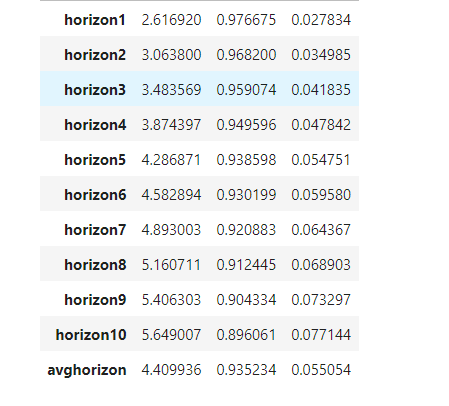

In [50]:
postfix = ""
save_metrics_df.to_excel(f"./save_file/{prefix}_{cosumized}horizons{postfix}.xlsx")

## plot

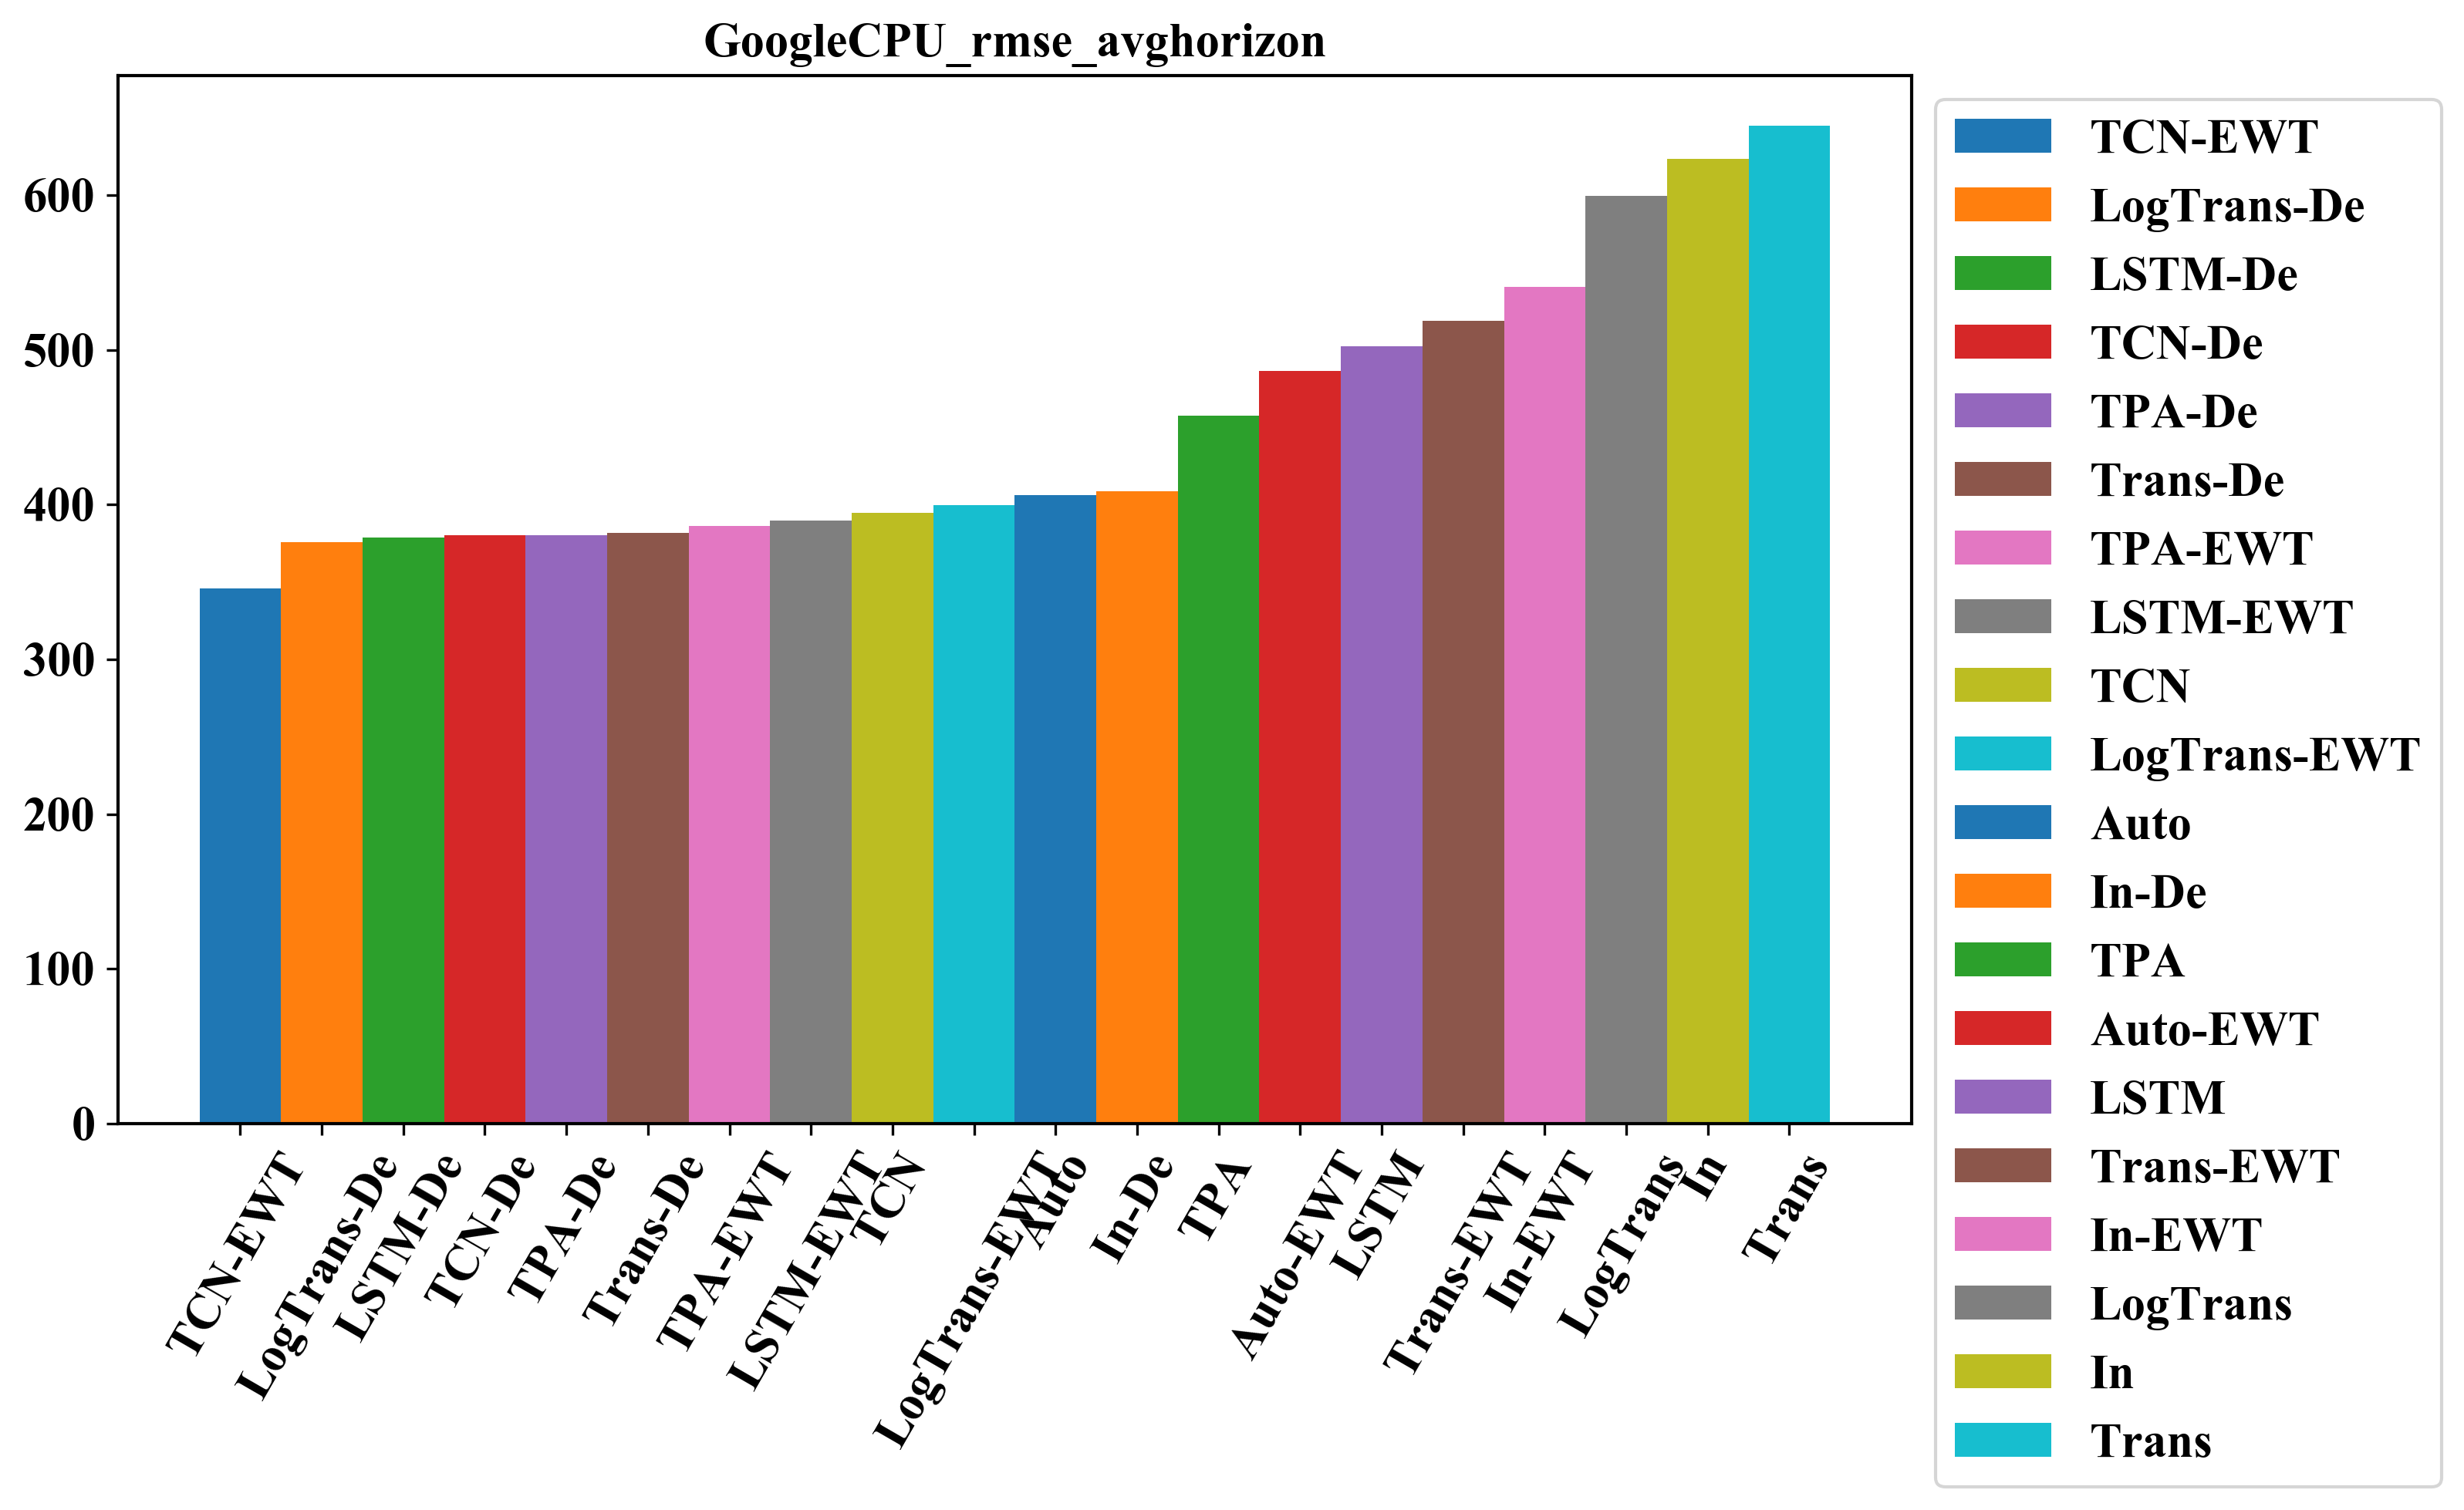

In [51]:
taget_indictor = 'rmse'
target_horizon = "avghorizon"
fig, hist_dict = evaluation_show(taget_indictor, target_horizon, metrics_dict=plot_metrics_dict, rotation=plot_rotation)

In [52]:
# metrics_dict.update(**former_metrics_dict)

In [53]:
# fig.savefig(f"D:/汇报/Fig/{prefix}_{plot_cosumized}{taget_indictor}.pdf", bbox_inches="tight", dpi=300)

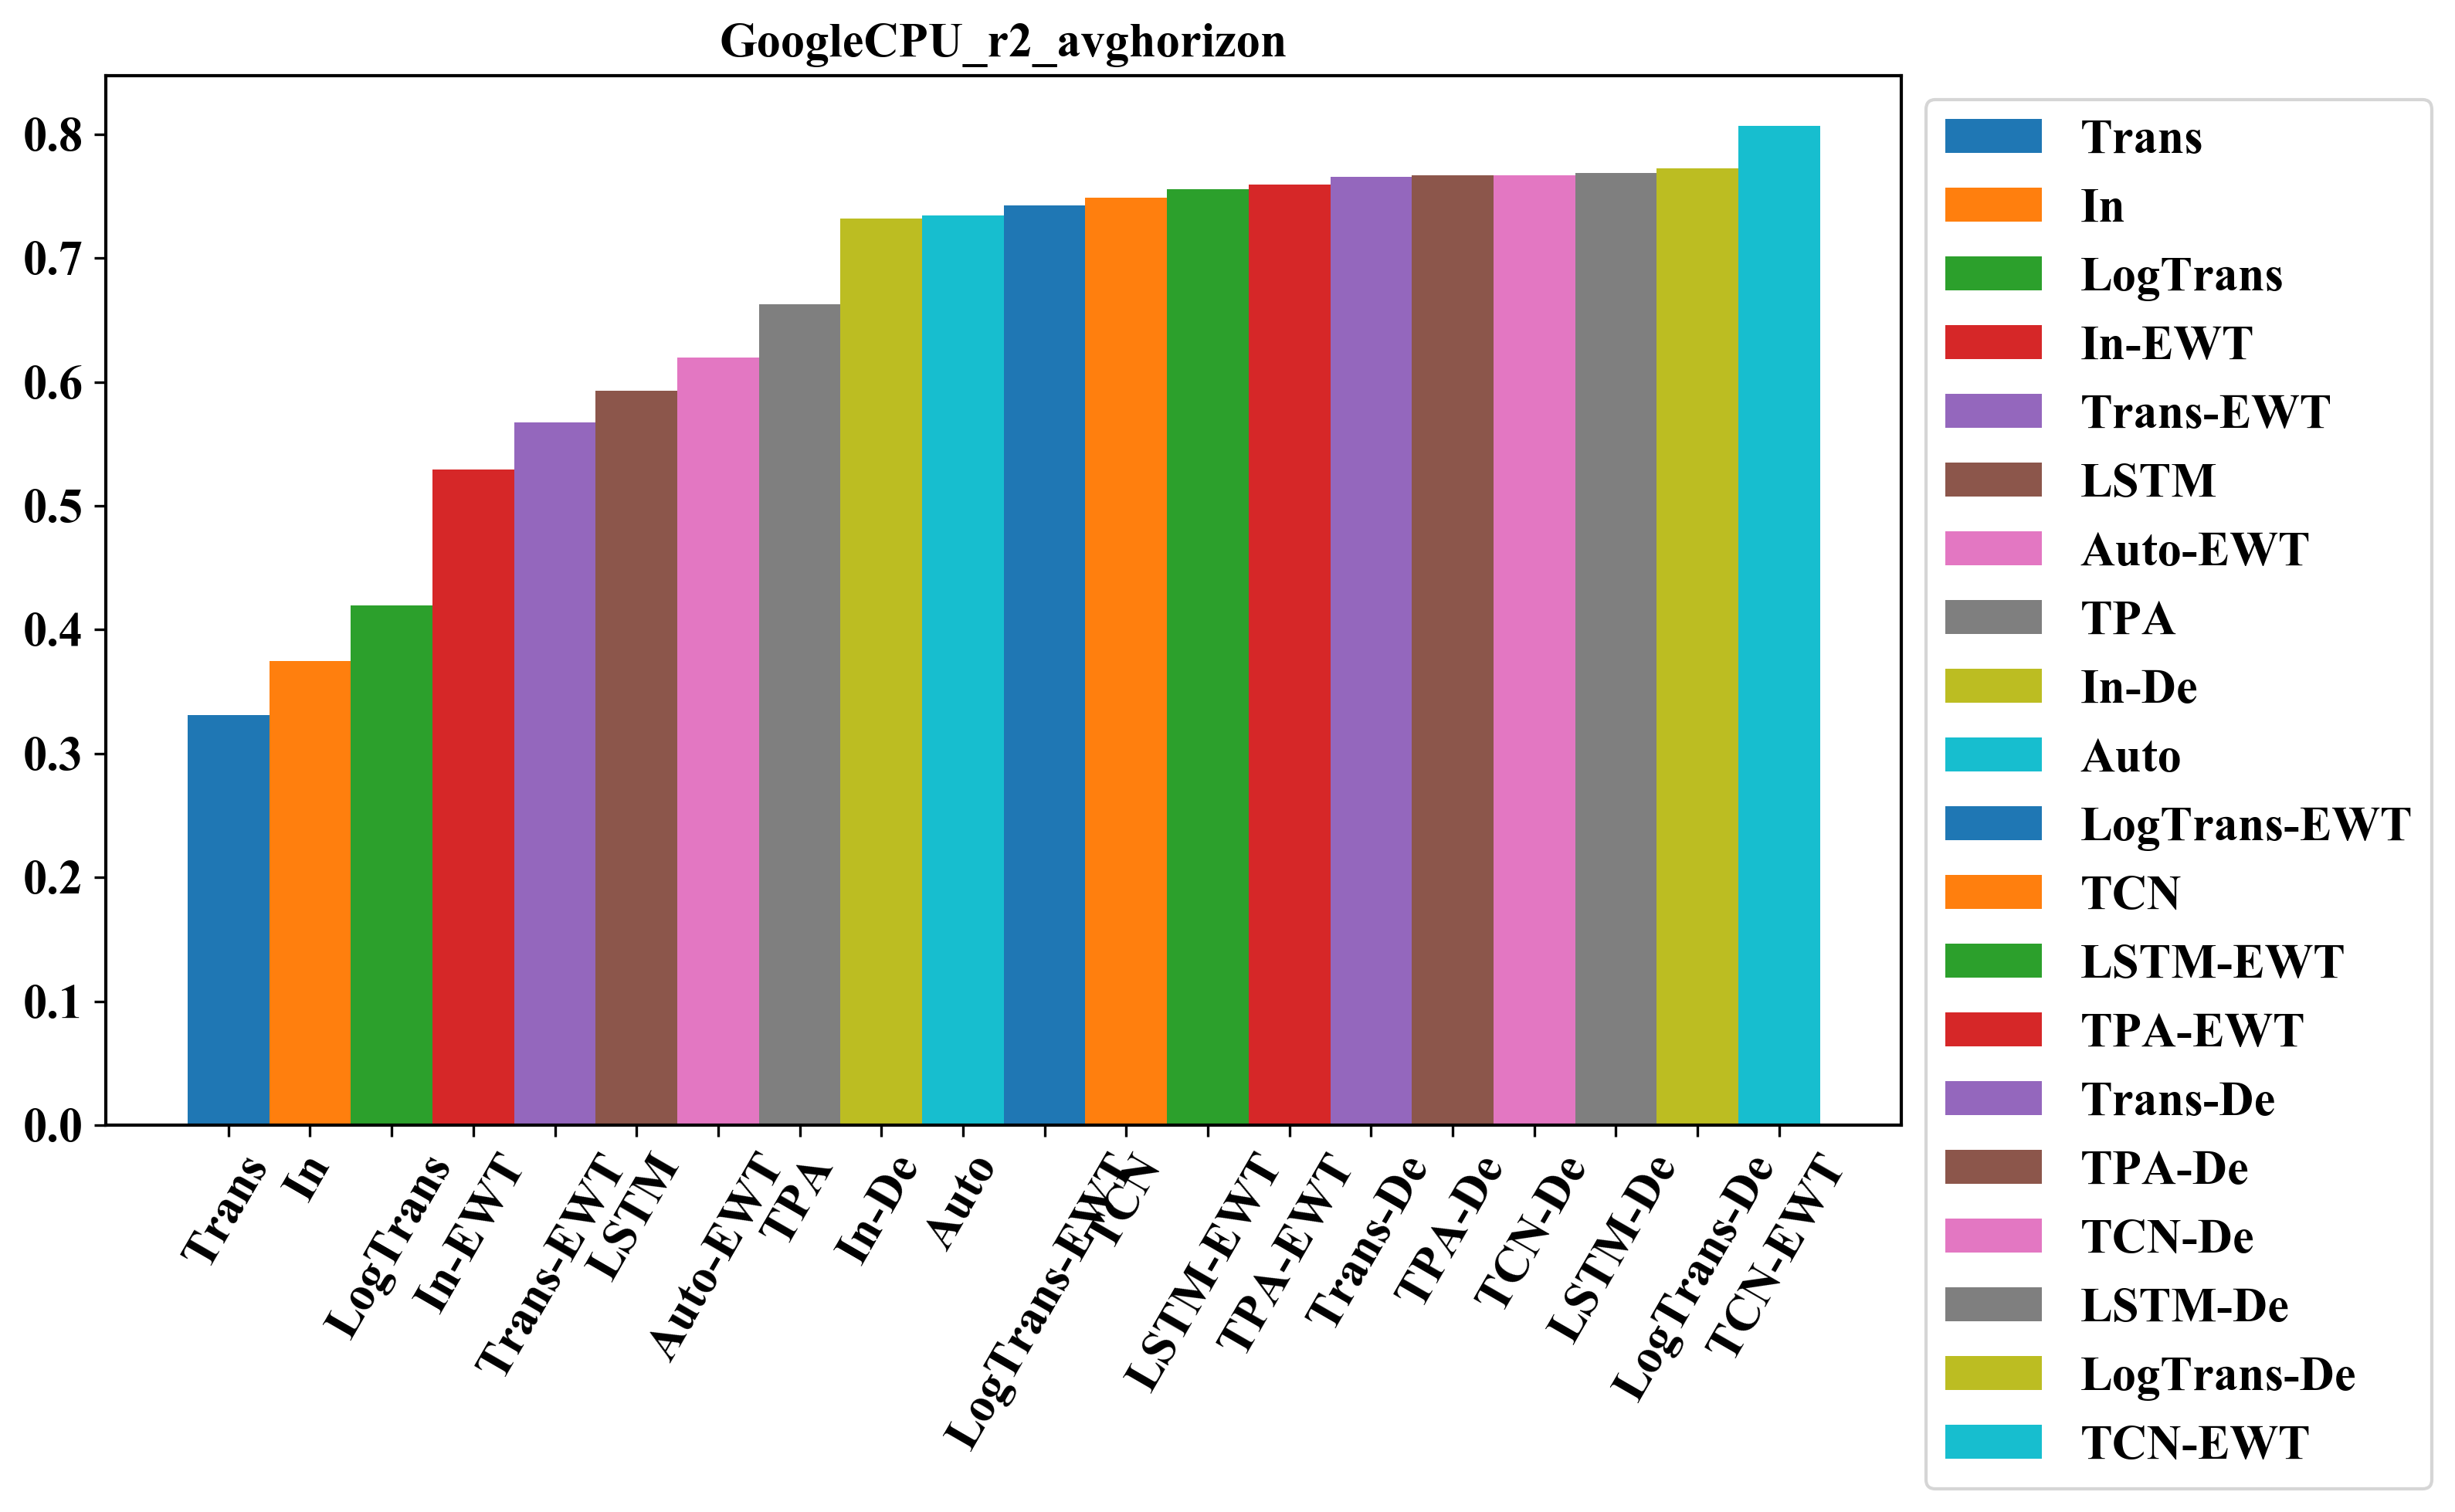

In [54]:
taget_indictor = 'r2'
fig, hist_dict = evaluation_show(taget_indictor, target_horizon, metrics_dict=plot_metrics_dict, rotation=plot_rotation)

In [55]:
# fig.savefig(f"D:/汇报/Fig/{prefix}_{plot_cosumized}{taget_indictor}.pdf", bbox_inches="tight", dpi=300)

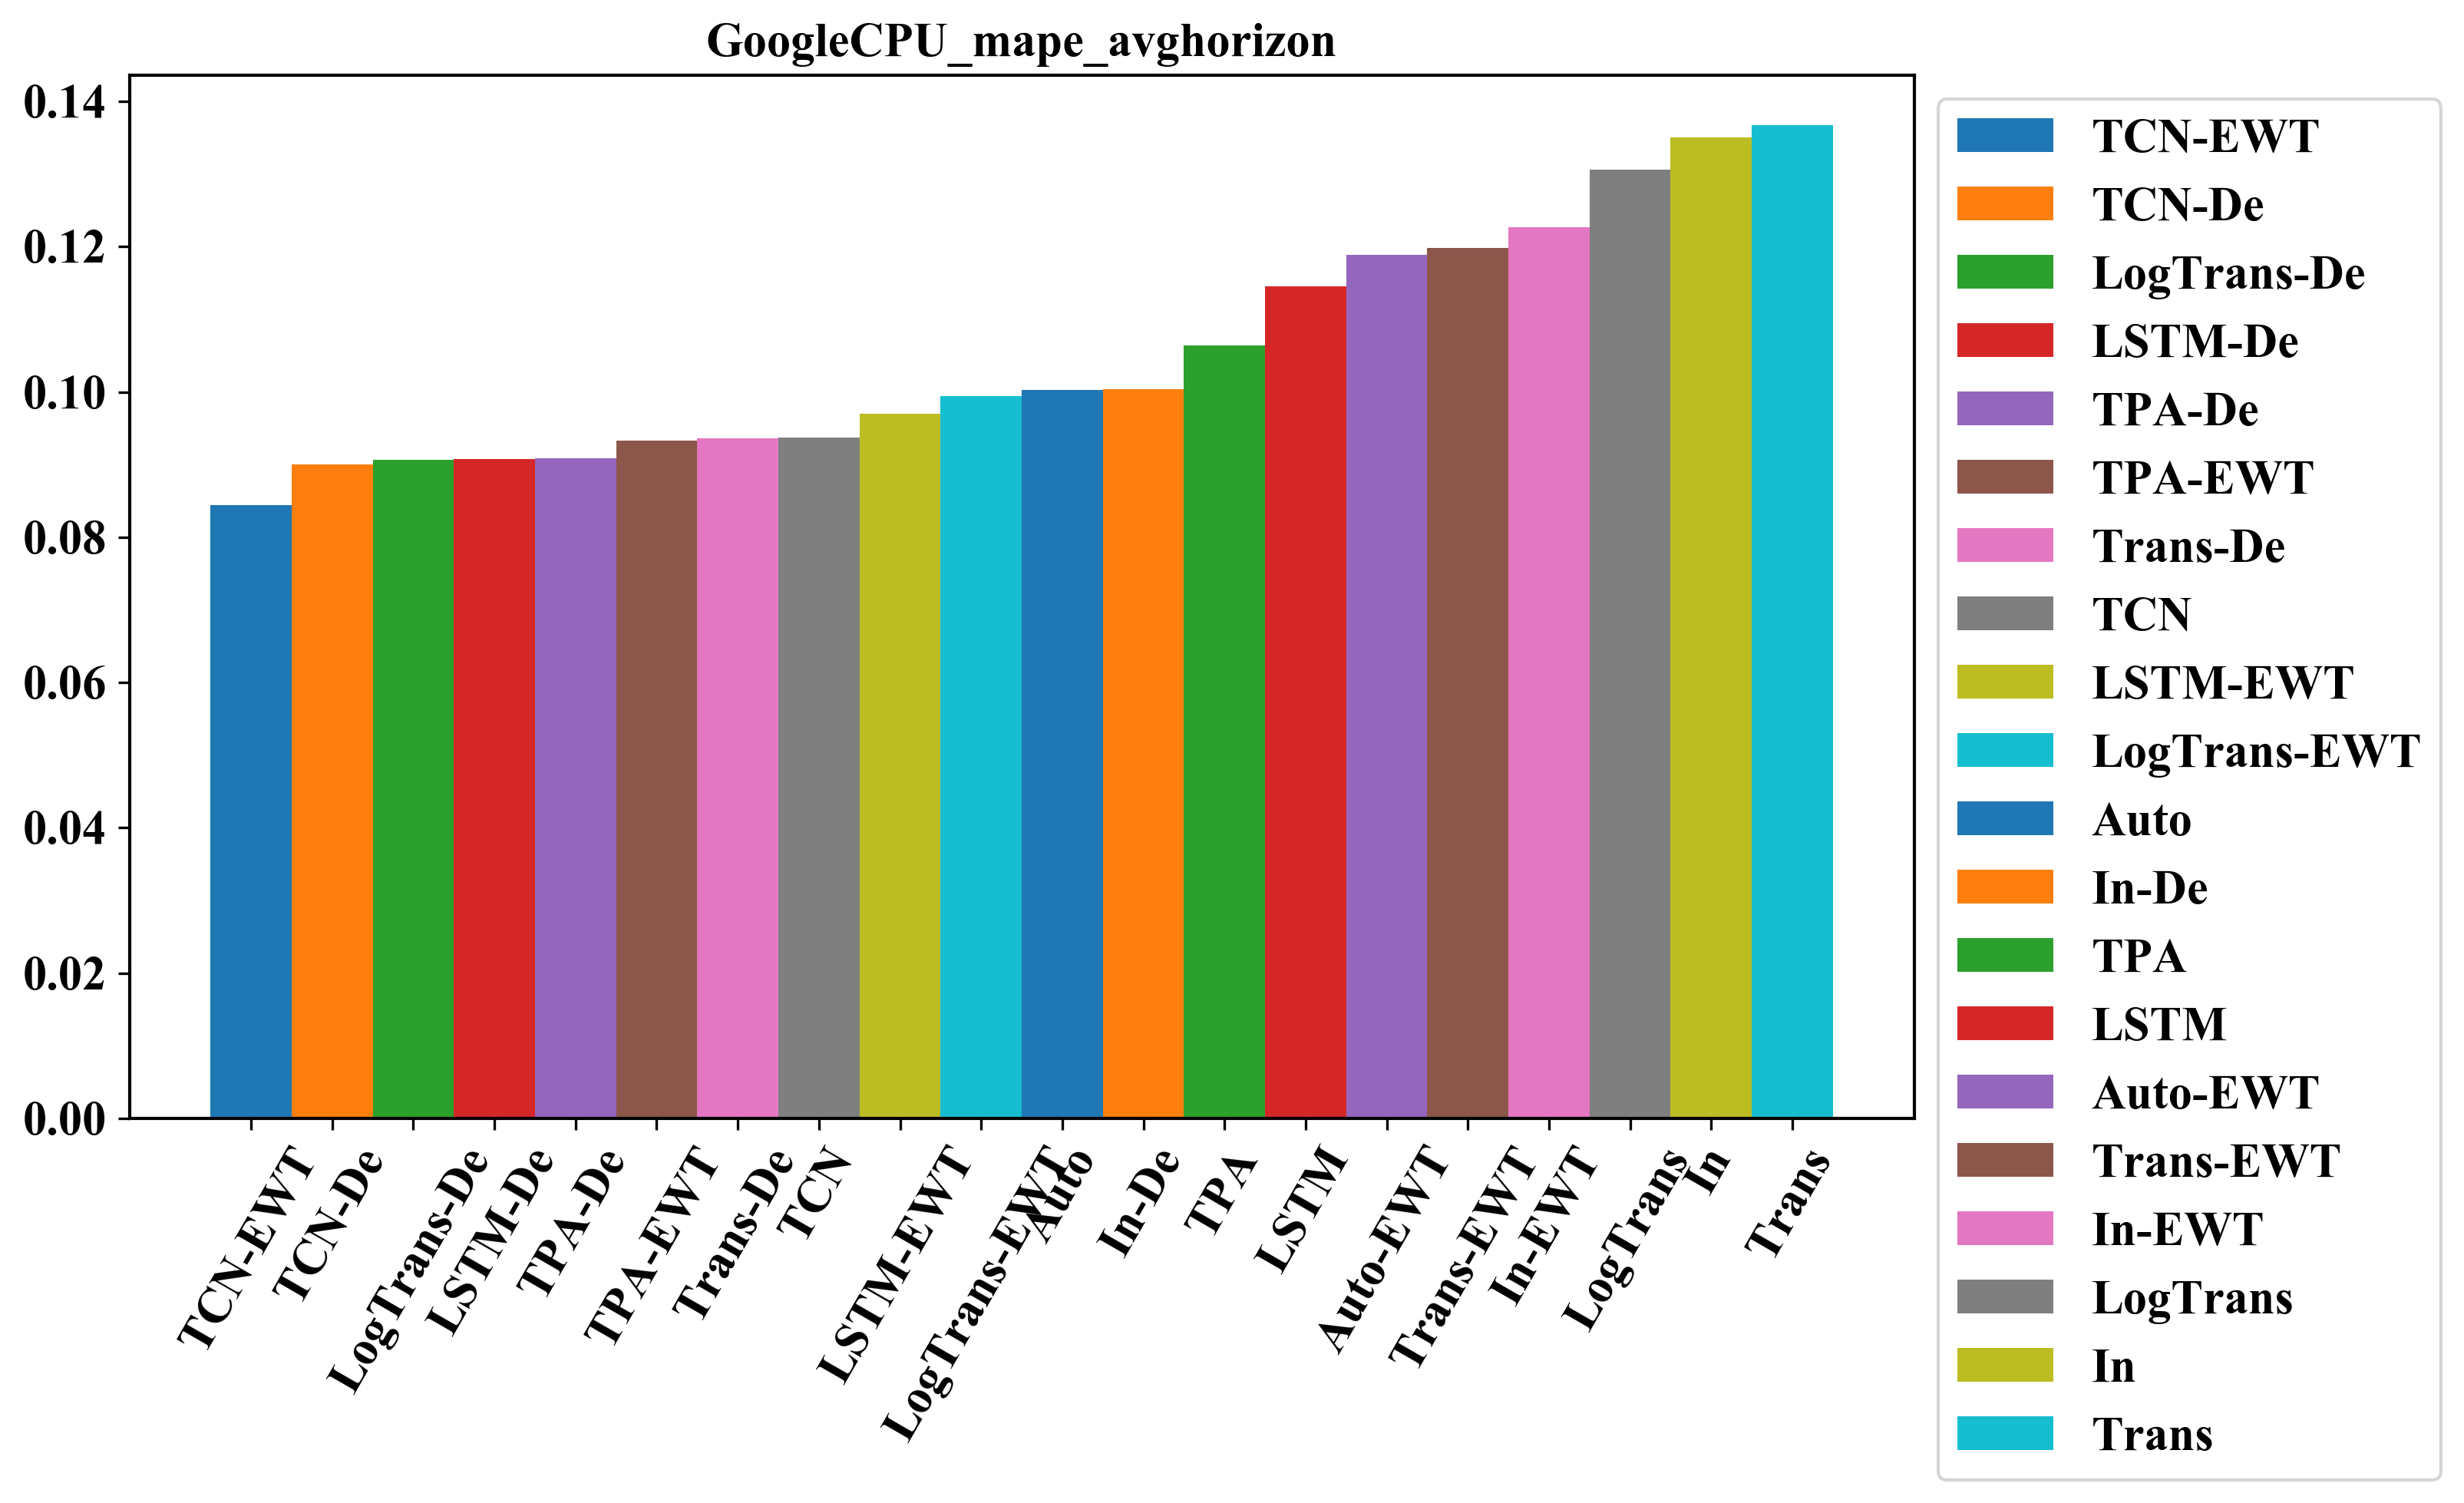

In [56]:
taget_indictor = 'mape'
fig, hist_dict = evaluation_show(taget_indictor, target_horizon, metrics_dict=plot_metrics_dict, rotation=plot_rotation)

In [57]:
# fig.savefig(f"D:/汇报/Fig/{prefix}_{plot_cosumized}{taget_indictor}.pdf", bbox_inches="tight", dpi=300)